In [226]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from vosk import Model
from Signal_Analysis.features.signal import get_HNR
from scipy import signal
from audiostretchy.stretch import stretch_audio
import pandas as pd
import librosa as lib
from sklearn import cluster
from sklearn.ensemble import IsolationForest
import sklearn as sk
from sklearn import tree

# tools work in progress
import tools

reload(tools)

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")

## data

i skymningen en mycket het dag i början av juli lämnade en ung man sin kammare som han hörde vid s grand steg ut på gatan och började långsamt och med samma obeslutsam går bort mot jobb men lyckligtvis slapp han möter värdinnan i kappan fanns kammare som låg alldeles in under den höga fem veckor aning byggnadens tak liknande snart ska jag köpa en bostad värdinnan som hyrde ut vind skutan och höll honom med middag som jag mål och städning bodde för sig i en våningen trappar trappa ner och när han skulle ut måste hem passera värdinnan kex ingång där döden nästan alltid sture


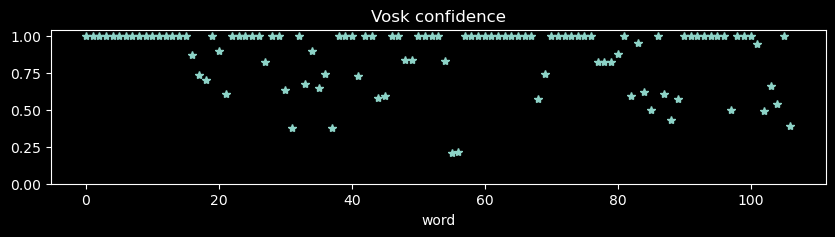

In [164]:
audio_path = "audio_preproc/180923214834-Y20UOTIE-text-000_pp.wav"
Fs, audio = wavfile.read(audio_path)

fl = int(0.02 * Fs)

audio_norm = audio / audio.std()
frames_all, f_start_all = tools.split_frames(audio_norm, fl, Fs, vol_thr=0.1)
f_start_all = f_start_all[:-1]
frames_all = np.array(frames_all[:-1])

model_path = "models/vosk-model-small-sv-rhasspy-0.15/"
if "model" not in locals():
    model = Model(model_path)

if "words" not in locals():
    words = tools.rec_vosk(audio_path, model, print_summary=True)

text = " ".join([w["word"] for w in words])


print(text)
plt.figure(figsize=(10, 2))
plt.plot([w["conf"] for w in words], "*")
plt.title("Vosk confidence")
plt.xlabel("word")
plt.ylim(bottom=0)
plt.show()

In [165]:
# get all vowels
for w in words:
    w["vowels"] = tools.checkVowels(w["word"], tools.VOWELS_SV)

for i, w in enumerate(words):
    print(i, w["word"], w["vowels"], str(w["conf"] * 100) + "%")

0 i ['i'] 100.0%
1 skymningen ['y', 'i', 'e'] 100.0%
2 en ['e'] 100.0%
3 mycket ['y', 'e'] 100.0%
4 het ['e'] 100.0%
5 dag ['a'] 100.0%
6 i ['i'] 100.0%
7 början ['ö', 'a'] 100.0%
8 av ['a'] 100.0%
9 juli ['u', 'i'] 100.0%
10 lämnade ['ä', 'a', 'e'] 100.0%
11 en ['e'] 100.0%
12 ung ['u'] 100.0%
13 man ['a'] 100.0%
14 sin ['i'] 100.0%
15 kammare ['a', 'a', 'e'] 100.0%
16 som ['o'] 87.0501%
17 han ['a'] 73.67869999999999%
18 hörde ['ö', 'e'] 70.1671%
19 vid ['i'] 100.0%
20 s [] 89.281%
21 grand ['a'] 60.827799999999996%
22 steg ['e'] 100.0%
23 ut ['u'] 100.0%
24 på ['å'] 100.0%
25 gatan ['a', 'a'] 100.0%
26 och ['o'] 100.0%
27 började ['ö', 'a', 'e'] 81.8951%
28 långsamt ['å', 'a'] 100.0%
29 och ['o'] 100.0%
30 med ['e'] 63.4952%
31 samma ['a', 'a'] 37.5446%
32 obeslutsam ['o', 'e', 'u', 'a'] 100.0%
33 går ['å'] 67.3912%
34 bort ['o'] 89.4242%
35 mot ['o'] 64.3671%
36 jobb ['o'] 73.9019%
37 men ['e'] 37.8958%
38 lyckligtvis ['y', 'i', 'i'] 100.0%
39 slapp ['a'] 100.0%
40 han ['a'] 100.0%

In [166]:
words_conf1 = [w for w in words if w["conf"] >= 1]

segments, vowels_per_segment = tools.segment_by_words(
    words, audio, Fs, tools.VOWELS_SV, signal_pad=0.02
)
segments_conf1 = []

for i, w in enumerate(words):
    if w["conf"] >= 1:
        segments_conf1.append(segments[i])


## Look at one word

mycket
['y', 'e']
mfcc (19, 5)
x (6, 5)
[0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
0.3684210526315789


c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


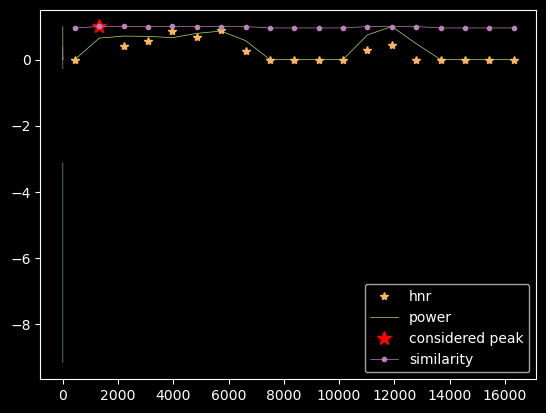

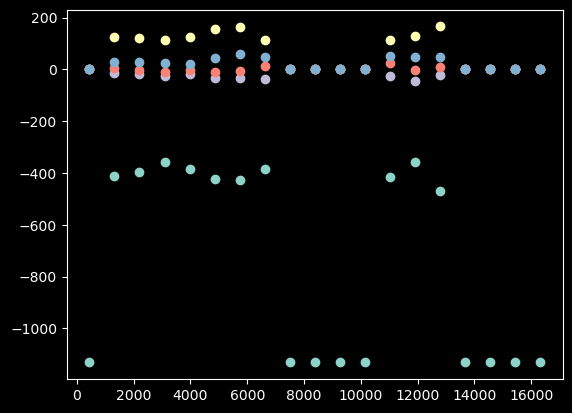

In [244]:
reload(tools)
k = 3
w = words_conf1[k]

print(w["word"])

x = segments_conf1[k] / segments_conf1[k].max()
x = np.concatenate((np.zeros(fl), x, np.zeros(fl)))
vowels = w["vowels"]
print(vowels)

frames, f_start = tools.split_frames(
    x, fl, Fs, overlap=0, vol_thr=0.1, print_info=False
)

peak_frames, hnr_frames = tools.HNR_short(frames, Fs, len(vowels))

hnr_env = tools.envelope(hnr_frames, 1, 1)
power_frames = np.array([np.mean(f**2) for f in frames])

mfcc_frames = np.array(tools.get_mfcc(frames, Fs, n=5))
print("mfcc", mfcc_frames.shape)
# look at one peak
p = peak_frames[0]
f = frames[p]

mfcc_peak = mfcc_frames[p]
mfcc_sim = np.array(
    [
        np.dot(mfcc_peak, f) / (np.linalg.norm(mfcc_peak) * np.linalg.norm(f))
        for f in mfcc_frames
    ]
)

## Classify
x = mfcc_frames[[0, 1, 7, 8, 9, 11]]
y = np.zeros(len(x))
y[1] = 1

print("x", x.shape)
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)

inliers = clf.predict(mfcc_frames)

print(inliers)
print(sum(inliers / len(inliers)))


plt.figure()
plt.plot(x / x.max(), alpha=0.4)
plt.plot(f_start + fl / 2, hnr_frames / hnr_frames.max(), "*", label="hnr")
plt.plot(f_start + fl / 2, power_frames / power_frames.max(), "-", label="power")

plt.plot(
    f_start[p] + fl / 2,
    hnr_frames[p] / hnr_frames.max(),
    "*r",
    markersize=10,
    label="considered peak",
)
plt.plot(f_start + fl / 2, mfcc_sim / mfcc_sim.max(), ".-", label="similarity")
# plt.plot(f_start[inliers] + fl / 2, np.ones(len(inliers)) ** 2, "o", label="inlier")

plt.legend()
plt.show()

plt.figure()
plt.plot(f_start + fl / 2, mfcc_frames, "o")


### Look at every word

In [132]:
reload(tools)

grouped_frames = {v: [] for v in tools.VOWELS_SV}
grouped_features = {v: [] for v in tools.VOWELS_SV}
grouped_hnr = {v: [] for v in tools.VOWELS_SV}

for k, w in enumerate(words_conf1):
    word = w["word"]

    x = segments_conf1[k] / segments_conf1[k].max()
    x = np.concatenate((np.zeros(fl), x, np.zeros(fl)))
    vowels = w["vowels"]

    frames, f_start = tools.split_frames(
        x, fl, Fs, overlap=0, vol_thr=0.1, print_info=False
    )

    peak_frames, hnr_frames = tools.HNR_short(frames, Fs, len(vowels))

    for i, p in enumerate(peak_frames):
        v = vowels[i]
        f = frames[p]
        grouped_frames[v].append(f)
        mfcc = tools.get_mfcc(f, Fs)
        grouped_features[v].append(mfcc)
        grouped_hnr[v].append(hnr_frames[p])


In [127]:
print("# frames per vowel")
for v in grouped_frames.keys():
    print(v, len(grouped_frames[v]))

# features_df = pd.DataFrame.from_dict(grouped_features)

# display(features_df.head())

# frames per vowel
ö 4
i 16
o 10
e 20
å 3
y 4
u 8
a 31
ä 6


(20, 50)
(0, array([7.62939453e-06, 9.60422686e+01, 1.00780938e+02, 5.55647374e+01,
       8.20260017e+01, 4.97791567e+01, 1.45912605e+02, 9.07706322e+01,
       5.01913210e+01, 8.35977511e+01, 7.55201184e+01, 1.43450560e+02,
       8.08674925e+01, 7.69081391e+01, 1.10518296e+02, 8.82512494e+01,
       9.06135727e+01, 6.42882511e+01, 7.45667009e+01, 8.63648320e+01]))
(1, array([ 96.04226861,   0.        ,  79.51869847,  71.83187913,
        84.51312647,  91.66763012, 121.7906072 , 104.30389801,
        85.9299607 ,  91.35093974,  85.77940688, 100.9463333 ,
        92.17356787,  79.87356841,  76.88324329,  67.05961112,
        90.7077594 ,  80.1479599 , 118.81912205,  60.76970277]))
(1, array([100.78093827,  79.51869847,   0.        ,  68.00592875,
        67.26482624, 102.63552756,  93.96673791,  96.54829698,
        83.7052609 ,  85.46823889,  70.85623101, 119.94465286,
        56.46491046,  73.69097092,  52.53573229,  31.543346  ,
        66.82253436,  95.43616754, 132.21264284,  62.

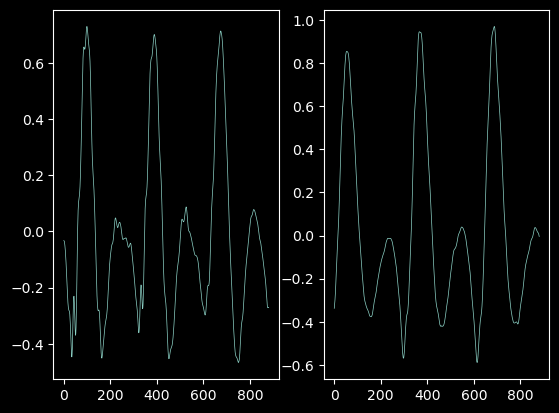

17.230688923294835 14.332656138477613


In [128]:
v = "e"
n_clust = 2
frames = grouped_frames[v]
X = np.array(grouped_features[v])
# X = np.array(np.array(grouped_hnr[v]).reshape(-1, 1))
print(X.shape)
km = cluster.Birch(n_clusters=n_clust).fit(X)

X_cluster = km.transform(X)

in_cluster = km.predict(X)

for r in zip(in_cluster, X_cluster):
    print(r)

X_in = [X_cluster[k] for k in range(len(in_cluster)) if in_cluster[k]]
print(len(X_in))

frames_in = [frames[k] for k in range(len(in_cluster)) if in_cluster[k]]
frames_out = [frames[k] for k in range(len(in_cluster)) if not in_cluster[k]]

hnr_in = [grouped_hnr[v][k] for k in range(len(in_cluster)) if in_cluster[k]]
hnr_out = [grouped_hnr[v][k] for k in range(len(in_cluster)) if not in_cluster[k]]


plt.figure()
plt.subplot(121)
plt.plot(frames_in[0])
plt.subplot(122)
plt.plot(frames_out[0])
plt.show()
print(hnr_in[0], hnr_out[0])

14.767957541132862 13.035610627394249


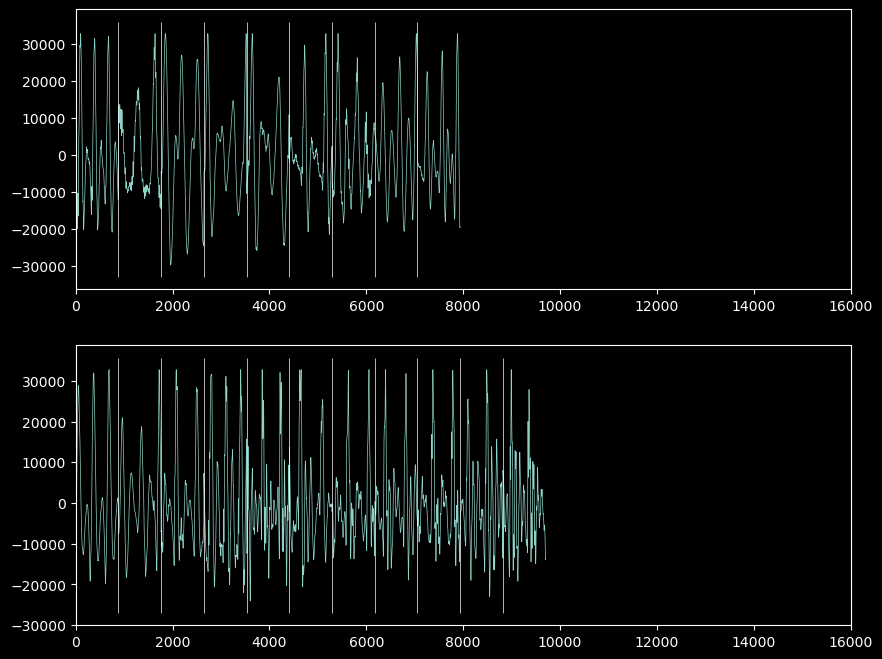

In [129]:
stitched = {}
stitched[v] = []

stitched[v].append(tools.stitch_frames(frames_in))
stitched[v].append(tools.stitch_frames(frames_out))

plt.figure(figsize=(10, 8))
for i in range(n_clust):
    plt.subplot(2, 1, i + 1)
    plt.plot(stitched[v][i])
    plt.xlim(0, 16000)
    plt.vlines(np.arange(stop=len(stitched[v][i]), step=fl), *plt.ylim())

    wavfile.write(f"output/clust{n_clust}_{i}.wav", Fs, stitched[v][i])

print(np.mean(hnr_in), np.mean(hnr_out))

## outliers?

inliers 70.0 %


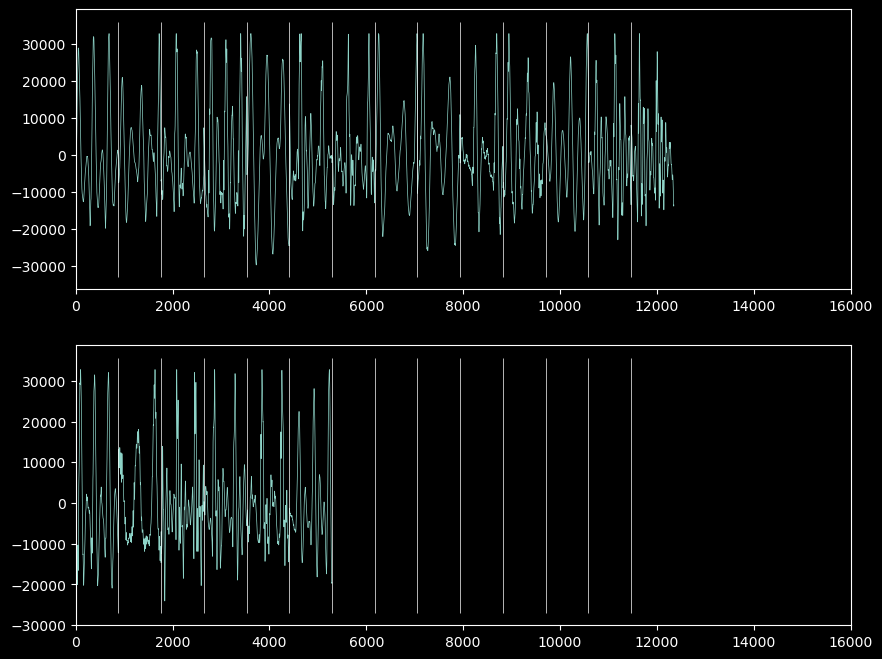

In [130]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=0)
clf.fit(X)

inliers = clf.predict(X) > 0

print(f"inliers {np.around(100*sum(inliers)/len(X))} %")

frames_inlier = []
frames_outlier = []
for k in range(len(inliers)):
    if inliers[k]:
        frames_inlier.append(grouped_frames[v][k])
    else:
        frames_outlier.append(grouped_frames[v][k])

stitched_in = tools.stitch_frames(frames_inlier)
stitched_out = tools.stitch_frames(frames_outlier)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(stitched_in)
plt.xlim(0, 16000)
plt.vlines(np.arange(stop=len(stitched_in), step=fl), *plt.ylim())
plt.subplot(2, 1, 2)
plt.plot(stitched_out)
plt.xlim(0, 16000)
plt.vlines(np.arange(stop=len(stitched_in), step=fl), *plt.ylim())

wavfile.write("output/liers_in.wav", Fs, stitched_in)
wavfile.write("output/liers_out.wav", Fs, stitched_out)

## DONT consider all frames

(2254, 882)


c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


(2254, 5)


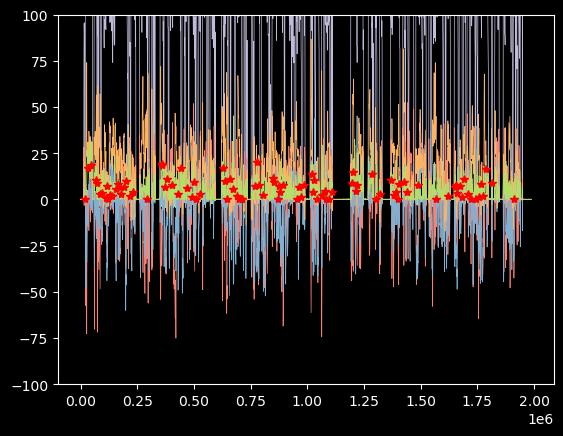

In [131]:
reload(tools)

print(frames_all.shape)

mfcc = tools.get_mfcc(frames_all, Fs, n=5).T
hnr = np.array([get_HNR(f, Fs) for f in frames_all])

print(mfcc.shape)

plt.figure()
plt.plot(audio_norm)
plt.plot(f_start_all, mfcc)
plt.plot(f_start_all, hnr)
plt.plot(f_start_all[is_vowel_all.astype(bool)], hnr[is_vowel_all.astype(bool)], "*r")
plt.ylim(-100, 100)
plt.show()
